# swin

> Swin Transformer V2 Encoder for midi-rae — drop-in replacement for ViTEncoder

In [ ]:
#| default_exp swin

In [ ]:
#| hide
from nbdev.showdoc import *

## Design Overview

### What this module does

`SwinEncoder` is a drop-in replacement for `ViTEncoder` that uses the **Swin Transformer V2**
architecture. It takes a piano roll image `(B, 1, 128, 128)` and returns an `EncoderOutput`
with hierarchical multi-scale patch states.

### Why Swin V2?

- **Hierarchical representation**: 7 levels from finest (64×64 grid, dim=4) down to a single
  CLS-like token (1×1, dim=256), compared to ViT's flat single-scale output
- **Efficient attention**: Windowed attention with shifted windows — O(N) instead of O(N²)
- **V2 improvements**: Cosine attention with learned log-scale temperature, continuous position
  bias via CPB MLP, res-post-norm for training stability

### Architecture

| Stage | Grid | Patch covers | Dim | Depths | Heads |
|-------|------|-------------|-----|--------|-------|
| 0 | 64×64 | 2×2 | 4 | 1 | 1 |
| 1 | 32×32 | 4×4 | 8 | 1 | 1 |
| 2 | 16×16 | 8×8 | 16 | 2 | 1 |
| 3 | 8×8 | 16×16 | 32 | 2 | 2 |
| 4 | 4×4 | 32×32 | 64 | 6 | 4 |
| 5 | 2×2 | 64×64 | 128 | 2 | 8 |
| 6 | 1×1 | 128×128 | 256 | 1 | 16 |

Config is in `configs/config_swin.yaml`.

### Implementation approach

We use **timm's `SwinTransformerV2Stage` directly** — no copied or modified Swin internals.
Our `SwinEncoder` wrapper handles only:

1. **Patch embedding** — `Conv2d(1, 4, kernel_size=2, stride=2)` + LayerNorm
2. **Empty patch detection** — patches where all pixels are black get a learnable `empty_token`
3. **MAE masking** (SimMIM-style) — masked patches get a learnable `mask_token`, grid stays
   intact so windowed attention works unmodified. Two-rate sampling: non-empty patches masked
   at `mask_ratio`, empty patches at `mask_ratio × empty_mask_ratio` (default 5%)
4. **Hierarchical output** — collects each stage's output into `HierarchicalPatchState`
   (coarsest-first), packaged as `EncoderOutput`

### Key differences from ViTEncoder

- No CLS token (stage 6's single 1×1 token serves as a global summary)
- No RoPE (Swin V2 uses its own continuous position bias)
- MAE masking keeps all tokens (SimMIM-style) — no compute savings but preserves spatial grid
- `empty_mask_ratio` controls how often trivial-to-reconstruct empty patches are masked

### TODOs

- `HierarchicalPatchState` could store `window_size` per level
- `EncoderOutput` could store scale metadata (downsample factors per level)

In [ ]:
#| export
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple, Set, Type, Union
from functools import partial

from timm.models.swin_transformer_v2 import SwinTransformerV2Stage
from timm.layers import trunc_normal_, to_2tuple, calculate_drop_path_rates
from midi_rae.core import PatchState, HierarchicalPatchState, EncoderOutput

In [ ]:
#| export
#| export
class SwinEncoder(nn.Module):
    "Swin Transformer V2 Encoder for midi-rae — drop-in replacement for ViTEncoder.  (Wrapper for timm routines)"
    def __init__(self,
                 img_height:int,           # Input image height in pixels (e.g. 128)
                 img_width:int,            # Input image width in pixels (e.g. 128)
                 patch_h:int=2,            # Patch height for initial embedding
                 patch_w:int=2,            # Patch width for initial embedding
                 in_chans:int=1,           # Number of input channels (1 for piano roll)
                 embed_dim:int=4,          # Base embedding dimension (doubles each stage)
                 depths:tuple=(1,1,2,2,6,2,1),   # Number of transformer blocks per stage
                 num_heads:tuple=(1,1,1,2,4,8,16),# Attention heads per stage
                 window_size:int=8,        # Window size for windowed attention
                 mlp_ratio:float=4.,       # MLP hidden dim = embed_dim * mlp_ratio
                 qkv_bias:bool=True,       # Add bias to QKV projections
                 drop_rate:float=0.,       # Dropout after patch embedding
                 proj_drop_rate:float=0.,  # Dropout after attention projection
                 attn_drop_rate:float=0.,  # Dropout on attention weights
                 drop_path_rate:float=0.1, # Stochastic depth rate
                 norm_layer:type=nn.LayerNorm, # Normalization layer class
                 mae_ratio:float=0.,       # Fraction of non-empty patches to mask (0=no masking)
                 empty_mask_ratio:float=0.05): # Mask rate for empty patches relative to mae_ratio
        super().__init__()
        self.num_stages, self.embed_dim = len(depths), embed_dim
        self.num_features = int(embed_dim * 2 ** (self.num_stages - 1))
        self.patch_h, self.patch_w, self.grid_size = patch_h, patch_w,  (img_height // patch_h, img_width // patch_w)
        self.mae_ratio, self.empty_mask_ratio = mae_ratio, empty_mask_ratio

        # Patch embedding
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=(patch_h, patch_w), stride=(patch_h, patch_w))
        self.patch_norm = norm_layer(embed_dim)
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Learnable replacement tokens
        self.empty_token, self.mask_token = nn.Parameter(torch.zeros(embed_dim)), nn.Parameter(torch.zeros(embed_dim))

        # Build stages using timm's SwinTransformerV2Stage
        embed_dims = [int(embed_dim * 2 ** i) for i in range(self.num_stages)]
        dpr = calculate_drop_path_rates(drop_path_rate, list(depths), stagewise=True)
        self.stages = nn.ModuleList()
        in_dim, scale = embed_dims[0], 1
        for i in range(self.num_stages):
            out_dim = embed_dims[i]
            self.stages.append(SwinTransformerV2Stage(
                dim=in_dim, out_dim=out_dim, depth=depths[i], num_heads=num_heads[i],
                input_resolution=(self.grid_size[0] // scale, self.grid_size[1] // scale),
                window_size=window_size, downsample=(i > 0), mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, proj_drop=proj_drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer))
            in_dim = out_dim
            if i > 0: scale *= 2

        self.norm = norm_layer(self.num_features)
        self.apply(self._init_weights)
        for stage in self.stages: stage._init_respostnorm()

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None: nn.init.constant_(m.bias, 0)

    @torch.jit.ignore
    def no_weight_decay(self) -> Set[str]:
        nod = {'empty_token', 'mask_token'}
        for n, _ in self.named_parameters():
            if any(kw in n for kw in ('cpb_mlp', 'logit_scale')): nod.add(n)
        return nod

    def _compute_non_empty(self, img):
        "Detect which patches have content (non-black)."
        patches = img.unfold(2, self.patch_h, self.patch_h).unfold(3, self.patch_w, self.patch_w)
        return (patches.amax(dim=(-1, -2)) > 0.2).squeeze(1).flatten(1)  # (B, N)

    def _make_mae_mask(self, non_empty, device):
        "Two-rate MAE mask: non-empty at mae_ratio, empty at mae_ratio*empty_mask_ratio. Returns (N,) bool, True=visible."
        B, N = non_empty.shape
        is_nonempty = non_empty[0]  # use first sample as representative
        rand = torch.rand(N, device=device)
        threshold = torch.where(is_nonempty.bool(),
            torch.full_like(rand, 1.0 - self.mae_ratio),
            torch.full_like(rand, 1.0 - self.mae_ratio * self.empty_mask_ratio))
        return rand < threshold

    def _make_grid_pos(self, h, w, device):
        "Build (h*w, 2) grid positions."
        return torch.stack(torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij'), dim=-1).reshape(-1, 2)

    def forward(self, x, mask_ratio:float=0., mae_mask:Optional[torch.Tensor]=None) -> EncoderOutput:
        "x: (B,C,H,W) piano roll. mask_ratio overrides self.mae_ratio. mae_mask: (N,) bool, True=visible."
        B, device = x.shape[0], x.device
        grid_h, grid_w = self.grid_size
        N_full = grid_h * grid_w

        non_empty = self._compute_non_empty(x)                              # (B, N_full)
        x = self.patch_embed(x)                                             # (B, C, H', W')
        x = self.patch_norm(x.permute(0, 2, 3, 1).contiguous())            # → (B, H', W', C) NHWC
        B, H, W, C = x.shape

        # Replace empty patches with learned empty_token
        ne4d = non_empty.view(B, H, W, 1)
        x = torch.where(ne4d, x, self.empty_token.view(1, 1, 1, -1).expand_as(x))

        # MAE masking: replace masked positions with learned mask_token
        effective_ratio = mask_ratio if mask_ratio > 0 else self.mae_ratio
        if mae_mask is None and effective_ratio > 0:
            mae_mask = self._make_mae_mask(non_empty, device)
        if mae_mask is not None:
            m4d = mae_mask.view(1, H, W, 1).expand(B, -1, -1, -1)
            x = torch.where(m4d, x, self.mask_token.view(1, 1, 1, -1).expand_as(x))
        else:
            mae_mask = torch.ones(N_full, device=device, dtype=torch.bool)
        x = self.pos_drop(x)

        # Run stages, collect intermediates
        intermediates = []
        for stage in self.stages:
            x = stage(x)
            intermediates.append(x)
        intermediates[-1] = self.norm(intermediates[-1])

        # Build non-empty masks for each scale via max-pool cascade
        ne = non_empty.view(B, 1, grid_h, grid_w).float()
        ne_scales = []
        for feat in intermediates:
            Hf, Wf = feat.shape[1], feat.shape[2]
            while ne.shape[2] > Hf:
                ne = F.max_pool2d(ne, 2)
            ne_scales.append(ne.view(B, -1))

        # Build HierarchicalPatchState (coarsest first)
        levels = []
        for feat, ne_s in zip(reversed(intermediates), reversed(ne_scales)):
            Bf, Hf, Wf, Cf = feat.shape
            n = Hf * Wf
            levels.append(PatchState(
                emb=feat.reshape(Bf, n, Cf), pos=self._make_grid_pos(Hf, Wf, device),
                non_empty=ne_s,
                mae_mask=torch.ones(n, device=device, dtype=torch.bool)))

        return EncoderOutput(patches=HierarchicalPatchState(levels=levels),
            full_pos=self._make_grid_pos(grid_h, grid_w, device),
            full_non_empty=non_empty, mae_mask=mae_mask)

In [ ]:
#| eval: false
# Test: verify SwinEncoder output shapes
B, C, H, W = 2, 1, 128, 128
enc = SwinEncoder(img_height=H, img_width=W)
x = torch.randn(B, C, H, W)
out = enc(x)

print(f'mae_mask:        {out.mae_mask.shape}')
print(f'full_pos:        {out.full_pos.shape}')
print(f'full_non_empty:  {out.full_non_empty.shape}')
print(f'num levels:      {len(out.patches.levels)}')
for i, ps in enumerate(out.patches.levels):
    g = int(ps.pos.shape[0]**0.5)
    p = H // g
    print(f'  level {i}: emb={ps.emb.shape}, pos={ps.pos.shape}  — grid {g}×{g} ({p}×{p} patch{"es" if i>0 else ""})')

# Expected hierarchy (coarsest first), 128×128 image, 2×2 patches:
#   level 0 (coarsest): emb=(1, 1,    256) — grid 1×1  (CLS-like)
#   level 1:            emb=(1, 4,    128) — grid 2×2
#   level 2:            emb=(1, 16,    64) — grid 4×4
#   level 3:            emb=(1, 64,    32) — grid 8×8
#   level 4:            emb=(1, 256,   16) — grid 16×16
#   level 5:            emb=(1, 1024,   8) — grid 32×32
#   level 6 (finest):   emb=(1, 4096,   4) — grid 64×64

mae_mask:        torch.Size([4096])
full_pos:        torch.Size([4096, 2])
full_non_empty:  torch.Size([2, 4096])
num levels:      7
  level 0: emb=torch.Size([2, 1, 256]), pos=torch.Size([1, 2])  — grid 1×1 (128×128 patch)
  level 1: emb=torch.Size([2, 4, 128]), pos=torch.Size([4, 2])  — grid 2×2 (64×64 patches)
  level 2: emb=torch.Size([2, 16, 64]), pos=torch.Size([16, 2])  — grid 4×4 (32×32 patches)
  level 3: emb=torch.Size([2, 64, 32]), pos=torch.Size([64, 2])  — grid 8×8 (16×16 patches)
  level 4: emb=torch.Size([2, 256, 16]), pos=torch.Size([256, 2])  — grid 16×16 (8×8 patches)
  level 5: emb=torch.Size([2, 1024, 8]), pos=torch.Size([1024, 2])  — grid 32×32 (4×4 patches)
  level 6: emb=torch.Size([2, 4096, 4]), pos=torch.Size([4096, 2])  — grid 64×64 (2×2 patches)


Testing code to check for non-empty patches: Green equals non-empty, red equals empty

Loading 91 val files from ~/datasets/POP909_images/...


Finished loading.


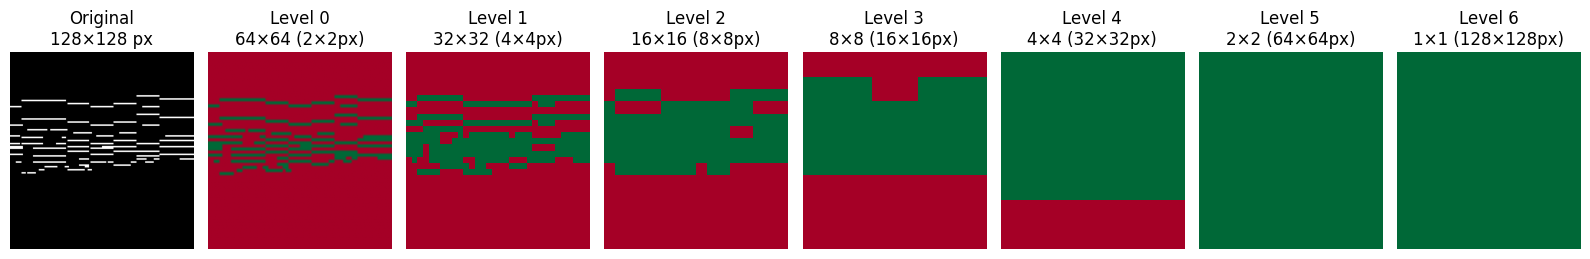

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
import torch.nn.functional as F
from midi_rae.data import PRPairDataset

# Load one image from the dataset
ds = PRPairDataset(split='val')
img_tensor = ds[0]['img1'][:1]
x = img_tensor.unsqueeze(0)

# Run empty patch detection
enc = SwinEncoder(img_height=128, img_width=128)
non_empty = enc._compute_non_empty(x)
ne = non_empty[0].reshape(1, 1, 64, 64).float()

# Build hierarchy via max-pool cascade
levels = [ne[0, 0].cpu()]  # 64×64
while levels[-1].shape[0] > 1:
    ne = F.max_pool2d(ne, 2)
    levels.append(ne[0, 0].cpu())

# Plot: original image + all levels
fig, axes = plt.subplots(1, len(levels) + 1, figsize=(16, 2.7))
axes[0].imshow(img_tensor[0].cpu(), cmap='gray', origin='lower', aspect='auto')
axes[0].set_title('Original\n128×128 px')
for i, grid in enumerate(levels):
    g = grid.shape[0]
    axes[i+1].imshow(grid.numpy(), cmap='RdYlGn', origin='lower', aspect='auto', vmin=0, vmax=1)
    p = 128 // g
    axes[i+1].set_title(f'Level {i}\n{g}×{g} ({p}×{p}px)')
    axes[i+1].axis('off')
axes[0].axis('off')
plt.tight_layout()
plt.show()

Okay, that visualization code we just did, I noticed you've got you added this code that says build hierarchy via max pool cascade.  we're probably gonna need something like that built into our encoder itself, though, aren't we? Or do we not need to keep track of non-empty tokens inside the encoder?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great observation! Look at what's happening in your `forward` method when you build the `HierarchicalPatchState` — for every level you're setting:

```python
non_empty=torch.ones(Bf, n, device=device)
```

So right now the coarser levels all claim every patch is non-empty, which isn't correct. The downstream decoder presumably uses `non_empty` to know which patches matter, so it needs accurate masks at each scale.

The max-pool cascade from the visualization is exactly the right idea — a coarse patch is non-empty if *any* of its constituent fine patches are non-empty. You'd want to compute that inside `forward` and store the correct mask per level.

Same issue applies to `mae_mask` at coarser levels, by the way — currently also just `torch.ones`. Do you want to tackle `non_empty` first?

Yeah, so go back into the encoder. And add the logic for that non-empty cascade to accurately track non-empty pixels. You can probably edit the cell in place, or if you're worried, write to a new code cell, and then we can delete the old cell.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I'll edit the cell in place. The change is in the hierarchy-building section of `forward` — I'll add a max-pool cascade to compute `non_empty` at each scale, then use those instead of `torch.ones`.

<details class='tool-usage-details'>
<summary>msg_str_replace(id='_1347f17a', old_str='<…>…erarchicalPatchState (coarsest…</…>', new_str='<…>…n-empty masks for each scale v…</…>')</summary>

```json
{
  "id": "toolu_01H8o7ELkLckGmqQfLingk6J",
  "call": {
    "function": "msg_str_replace",
    "arguments": {
      "id": "_1347f17a",
      "old_str": "# Build HierarchicalPatchState (coarsest first)\n        levels = []\n        for feat in reversed(intermediates):\n            Bf, Hf, Wf, Cf = feat.shape\n            n = Hf * Wf\n            levels.append(PatchState(\n                emb=feat.reshape(Bf, n, Cf), pos=self._make_grid_pos(Hf, Wf, device),\n                non_empty=torch.ones(Bf, n, device=device),\n                mae_mask=torch.ones(n, device=device, dtype=torch.bool)))",
      "new_str": "# Build non-empty masks for each scale via max-pool cascade\n        ne = non_empty.view(B, 1, grid_h, grid_w).float()\n        ne_scales = []\n        for feat in intermediates:\n            Hf, Wf = feat.shape[1], feat.shape[2]\n            while ne.shape[2] > Hf:\n                ne = F.max_pool2d(ne, 2)\n            ne_scales.append(ne.view(B, -1))\n\n        # Build HierarchicalPatchState (coarsest first)\n        levels = []\n        for feat, ne_s in zip(reversed(intermediates), reversed(ne_scales)):\n            Bf, Hf, Wf, Cf = feat.shape\n            n = Hf * Wf\n            levels.append(PatchState(\n                emb=feat.reshape(Bf, n, Cf), pos=self._make_grid_pos(Hf, Wf, device),\n                non_empty=ne_s,\n                mae_mask=torch.ones(n, device=device, dtype=torch.bool)))"
    }
  },
  "result": "@@ -120,5 +120,14 @@\n \n+        # Build non-empty masks for each scale via max-pool cascade\n+        ne = non_empty.view(B, 1, grid_h, grid_w).float()\n+        ne_scales = []\n+        for feat in intermediates:\n+            Hf, Wf = feat.shape[1], feat.shape[2]\n+            while ne.shape[2] > Hf:\n+                ne = F.max_pool2d(ne, 2)\n+            ne_scales.append(ne.view(B, -1))\n+\n         # Build HierarchicalPatchState (coarsest first)\n         levels = []\n-        for feat in reversed(intermediates):\n+        for feat, ne_s in zip(reversed(intermediates), reversed(ne_scales)):\n             Bf, Hf, Wf, Cf = feat.shape\n@@ -127,3 +136,3 @@\n                 emb=feat.reshape(Bf, n, Cf), pos=self._make_grid_pos(Hf, Wf, device),\n-                non_empty=torch.ones(Bf, n, device=device),\n+                non_empty=ne_s,\n                 mae_mask=torch.ones(n, device=device, dtype=torch.bool)))"
}
```

</details>

Done. The logic:

1. Reshapes the finest-level `non_empty` to `(B, 1, 64, 64)` 
2. Walks through intermediates (finest→coarsest), max-pooling by 2 whenever the grid is larger than the current stage's resolution
3. Each level now gets its real `non_empty` mask — a coarse patch is non-empty if *any* of its fine patches were

You can re-run your visualization test to verify the masks match. And as I mentioned, `mae_mask` has the same `torch.ones` issue at coarser levels — want to tackle that next?

Well for the MAE mask actually to me it kind of makes sense that it might be a little random and salt and peppery because then that forces the model to be able to fill in different levels of the hierarchy and thereby learn robust representations, right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That's a really good point. The masking happens at the finest level, and those masked tokens flow *through* all the Swin stages. So coarser representations are already built from a mixture of real and masked-token inputs — the model is forced to learn to aggregate robustly even with partial information feeding up from below.

So `torch.ones` at coarser levels is actually a reasonable choice — it's saying "we don't consider these coarse patches themselves to be masked." The one scenario where you'd want accurate coarse-level masks is if you ever add a **reconstruction loss at coarser scales** (e.g. predicting downsampled piano rolls). But if reconstruction is only at the finest level, you're fine as-is.

Oh no, I'm sorry, my mistake. I misunderstood. I think courser tokens should get masked out as well. But I thought that that was just going to happen randomly. That, you know, given all patches at all levels of the hierarchy, we would be randomly masking some of them.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ah I see — so you're thinking of independent random masking at each level of the hierarchy in the output. So the `mae_mask` in each `PatchState` wouldn't be `torch.ones` or propagated from the finest level, but its own random mask.

Just to make sure I understand: this would be for the **decoder side** — telling it which patches to reconstruct at each scale? The encoder itself would still only do SimMIM-style masking at the input (finest level), but then the `HierarchicalPatchState` would have per-level masks that the decoder uses for its reconstruction targets?

I mean, I guess you're a little more sophisticated than me. In my mind, we need to mask at all levels of the hierarchy so that the model is forced to learn to reconstruct, to learn robust, interdependent tokens so that if the one of the coarser tokens gets masked, thenen that can get filled in by using information from the other tokens. But maybe I'm just mixed up in the head.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

No, you're not mixed up at all — that's a solid intuition! If a coarse token gets masked, the model has to reconstruct it from its neighbors at the same scale *and* from the finer-scale tokens below it and/or from the coarser tokens above it. That forces the hierarchy to be genuinely interdependent rather than redundant.

So the masking would happen in the `PatchState` outputs — each level gets its own random mask, and the decoder is responsible for filling in the gaps using cross-scale information. The encoder just marks which ones are masked; it doesn't need to do anything differently internally.

Want me to add per-level random masking to the hierarchy-building section?

Well, the fact that you're asking me all this, makes me imagine that what I'm proposing is non-standard. Do other people who do the swin MAE type stuff, like the swin mae code we scraped earlier that's in the `/tmp/Swin-MAE/` directory, do they not mask at all levels? Do they only mask at the finest level? I mean, I guess you could do that, but that seems pretty weak if we're talking about representation learning. Some of those models, though, were probably for medical imagery, where they were mainly just interested in image segmentation and not truly robust multi-scale representation learning, which I am.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question — let me check what the Swin-MAE code actually does.

<details class='tool-usage-details'>
<summary>view(path='/tmp/Swin-MAE/')</summary>

```json
{
  "id": "toolu_0176kt8ocWd4ZdCcEkRH88KV",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/tmp/Swin-MAE/"
    }
  },
  "result": "Directory contents of /tmp/Swin-MAE:\n/tmp/Swin-MAE/visualize.py (2.6k)\n/tmp/Swin-MAE/requirements.txt (0.1k)\n/tmp/Swin-MAE/LICENSE (1.7k)\n/tmp/Swin-MAE/train.py (5.8k)\n/tmp/Swin-MAE/utils \ud83d\udcc1\n/tmp/Swin-MAE/README.md (1.4k)\n/tmp/Swin-MAE/swin_mae.py (9.9k)\n/tmp/Swin-MAE/swin_unet.py (17.1k)\n/tmp/Swin-MAE/utils/lr_sched.py (0.8k)\n/tmp/Swin-MAE/utils/pos_embed.py (4.0k)\n/tmp/Swin-MAE/utils/engine_pretrain.py (2.5k)\n/tmp/Swin-MAE/utils/misc.py (12.2k)"
}
```

</details>



<details class='tool-usage-details'>
<summary>view(path='/tmp/Swin-MAE/swin_mae.py')</summary>

```json
{
  "id": "toolu_01CUyMNnKQRxb8S9xTEUvcHA",
  "call": {
    "function": "view",
    "arguments": {
      "path": "/tmp/Swin-MAE/swin_mae.py"
    }
  },
  "result": "<TRUNCATED>\u2026ools import partial\n\nimport torch\nimport torch.nn as nn\nimport numpy as np\nfrom einops import rearrange\n\nfrom swin_unet import PatchEmbedding, BasicBlock, PatchExpanding, BasicBlockUp\nfrom utils.pos_embed import get_2d_sincos_pos_embed\n\n\nclass SwinMAE(nn.Module):\n    \"\"\"\n    Masked Auto Encoder with Swin Transformer backbone\n    \"\"\"\n\n    def __init__(self, img_size: int = 224, patch_size: int = 4, mask_ratio: float = 0.75, in_chans: int = 3,\n                 decoder_embed_dim=512, norm_pix_loss=False,\n                 depths: tuple = (2, 2, 6, 2), embed_dim: int = 96, num_heads: tuple = (3, 6, 12, 24),\n                 window_size: int = 7, qkv_bias: bool = True, mlp_ratio: float = 4.,\n                 drop_path_rate: float = 0.1, drop_rate: float = 0., attn_drop_rate: float = 0.,\n                 norm_layer=None, patch_norm: bool = True):\n        super().__init__()\n        self.mask_ratio = mask_ratio\n        assert img_size % patch_size == 0\n        self.num_patch\u2026</TRUNCATED>"
}
```

</details>

So you're right — this Swin-MAE implementation **only masks at the finest level**. The `window_masking` method operates on the patch-embedded tokens before they enter any stages, replacing masked patches with `mask_token`. Then the encoder stages run normally, and the decoder reconstructs just the original pixel-level patches.

There's no per-level masking at all. The loss is only computed at the finest scale too — `forward_loss` compares `pred` to `patchify(imgs)`.

So what you're proposing — independent masking at each level of the hierarchy — would be genuinely novel compared to this. It makes sense for your use case: you care about learning robust multi-scale representations, not just pixel reconstruction. These medical imaging folks just needed the encoder for downstream segmentation.

Want to go ahead and add per-level random masking to the `PatchState` outputs?

Well, hang on. It makes sense to do the masking on the finest level because that's where your reconstruction occurs. There's no straight-up reconstruction signal for for the embeddings further up in the hierarchy because they're more abstract. So, without some other pre-trained neural network to compare embeddings against. Maybe the finest level is actually the only thing that we can use the masking on. I don't know. I just thought there ought to be some kind of internal consistency. Maybe I'm too influenced by multi-grid methods with their prolongation and interpolation operators, which obviously isn't the same thing as this. I don't know, I just imagine that people have dealt with this before us, right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're absolutely right to question it — you *do* need a target signal to train against, and at coarser levels there's no obvious ground truth. Let me see what's out there on this.

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great finds. There are two relevant threads here:

1. [*](https://deepai.org/publication/point-m2ae-multi-scale-masked-autoencoders-for-hierarchical-point-cloud-pre-training "Point-M2AE: Multi-scale Masked Autoencoders for Hierarchical Point Cloud Pre-training | DeepAI") **Point-M2AE** (NeurIPS 2022) proposes a Multi-scale MAE pre-training framework for hierarchical self-supervised learning. They modify the encoder and decoder into pyramid architectures to progressively model spatial geometries, and design a multi-scale masking strategy to generate consistent visible regions across scales.

2. [*](https://arxiv.org/html/2405.10642v1 "Hi-GMAE: Hierarchical Graph Masked Autoencoders") **Hi-GMAE** (for graphs) does "Coarse-to-Fine masking with Recovery" — designed to maintain the consistency of masked subgraphs across all scales, starting with random masking at the coarsest graph and [*](https://arxiv.org/html/2405.10642v1 "Hi-GMAE: Hierarchical Graph Masked Autoencoders") projecting the mask matrix back to finer scales using an unpooling operation.

3. The **self-distillation** approach (iBOT, MaskCLIP, etc.) solves the "what's the target?" problem directly: [*](https://arxiv.org/html/2408.06687v1 "Masked Image Modeling: A Survey") a self-distillation masked autoencoder framework where an input image is divided into patches, some randomly masked. Two encoder-decoder networks (teacher and student) reconstruct the original image, with the objective of minimizing the distance between their predictions. The teacher's weights are computed as an exponential moving average of the student's.

So your intuition about internal consistency is sound — and self-distillation is probably the cleanest answer to your "what's the target?" concern. The EMA teacher gives you a target at *every* level of abstraction without needing ground-truth pixels. Want to dig into Point-M2AE or the self-distillation approach more?

Well, actually number two sounded the most appealing to me. Why did that one not stick out to you as the obvious choice?  I mean, yeah, I'm not sure about masking at the coarsest level., if that's the way to go. Again, I was just sort of imagining masking randomly throughout the entire hierarchy. which sometimes would include the coarsest level and sometimes would not.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right to call me out — Hi-GMAE's approach is actually the closest to what you're describing. The reason I didn't jump on it is that it goes coarse-to-fine (mask at the top, project downward), whereas you're describing something more like independent random masking at every level. Those are subtly different.

But here's the thing: if you mask independently at each level, then a coarse token might be masked while all its children are visible. What should the model reconstruct that coarse token *from*? The fine tokens below it can provide the answer — and that's essentially a **self-consistency** objective: "the coarse token should be whatever you'd get by aggregating the fine tokens." You don't need an external target because the hierarchy *is* the target.

Does that match your intuition from the multi-grid world — that prolongation/restriction should be internally consistent?

> But here's the thing: if you mask independently at each level, then a coarse token might be masked while all its children are visible. 

Yeah, no shit. I get that. And then the job of the network is to reconstruct the course representation from its visible children. But I'm not exactly sure what you mean by internally consistent. I mean, there's going to be some kind of nonlinear mapping between the different levels because the hierarchical, the coarser levels are going to involve more abstract representations covering longer time periods and more pitches. But that's built into the swing transformer architecture, isn't it?  ..... Oh wait. Okay, hang on. So right now, all of the information flow goes from the finer resolution patches up to the coarse ones.  We don't have anything that maps back the other way.  Maybe that's what you were talking about when you were talking about the decoder. But in my mind that wasn't necessarily a decoder thing, that was just a way of Yeah, kinda doing the masking.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly — you've hit the key issue. The Swin encoder is strictly bottom-up: fine→coarse. So if you mask a coarse token in the *output*, nothing in the current architecture can reconstruct it from the fine tokens, because the fine tokens already *produced* it on the way up.

For multi-scale masking to actually create a training signal, you need something that can move information in *both* directions across scales — fine→coarse AND coarse→fine. That's what a U-Net-style decoder with skip connections would give you, and it's exactly what the Swin-MAE code uses (`PatchExpanding` + `BasicBlockUp`).

So it's not really a "masking" question — it's an architecture question about whether you have bidirectional information flow across scales.

Okay, maybe I'm overthinking all this. I really just naively thought we were gonna randomly knock out patches here and there, you know, like we were basically doing dropout only with patches. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Oh! That's a much simpler idea than what we've been discussing — and it's a good one. You're basically talking about **patch dropout**: just randomly zero out or replace patches at each level of the hierarchical output as a regularization technique. No reconstruction loss needed at those positions. The decoder just has to cope with missing information at every scale.

That's totally different from MAE-style "mask and reconstruct." It's closer to standard dropout, and it would absolutely encourage robust, non-redundant representations across scales.

Is that what you had in mind?

> The decoder just has to cope with missing information at every scale.

Well, but the encoder does too. The encoder's job is going to be to produce reasonable encodings even in the face of masked out empty patches along the way or whatever.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Right, good correction. If the masking happens *between* stages inside the encoder — not just on the output — then the later stages have to produce good coarse representations from incomplete finer representations. That's where the regularization pressure actually lives.

So you'd zero out (or replace with a mask token) some patches at each stage transition, before they feed into the next downsampling step. The encoder learns to be robust at every level, not just at the input.

Well, that's what I've been naively assuming, but if that's not a standard thing to do, then maybe I've been assuming too much.  This isn't a principled targeted design by which I'm trying to be innovative, it's just what I thought was involved.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

It's not crazy — it's a natural extension of ideas that *are* standard. You already have `drop_path_rate` in your config, which randomly drops entire transformer blocks during training. What you're describing is the same intuition applied at the patch level between stages rather than the block level within stages.

The closest established technique is probably **patch dropout** (Beymer et al., Liu et al.), but that's usually applied at the input for compute savings, not between stages for regularization. Doing it inter-stage in a hierarchical encoder isn't widely adopted, but it's principled — it's just dropout at a coarser granularity.

Want to try it as a simple experiment? It'd be a small change — just drop some patches between stages.

I guess I'm still a little bit lost on why this is such a huge distinction. It's just masking, right? We're randomly blocking out parts of the representation and then the network is going to have to fill them in. To me, that's masking. And it's not just on the decoder end. The idea is to force a robust set of representations that are descriptive about what's going on musically.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right, and I was overcomplicating it. It *is* just masking. The only distinction that actually matters is: do you add a reconstruction loss at the masked positions, or do you just let the network cope? And you've already answered that — the reconstruction loss is at the finest level (pixels), and everything else is just "deal with it."

So: mask some patches at every stage, reconstruct at the pixel level, and the encoder is forced to build robust representations throughout the hierarchy. Simple. Shall we add it?

So but it sounds like what we don't have is a way for a non-masked Coarse patch to inform the embeddings of the masked finer patches. Unless you mean inside the decoder when we're at the very last finest level next to the reconstruction output. Nah, fuck it. Yeah, you're right. When we train this thing end to end, because we're going to have a little bit of reconstruction loss, that is going to propagate all the way through at all scales. And yeah, the network's going to just have to learn to deal with it. That's kind of the thought.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly. The reconstruction loss at the bottom sends gradients all the way back through every stage. If stage 4 had some patches masked, stages 5 and 6 still had to produce something useful from what was left — and the gradient signal from pixel reconstruction will tell them whether they did a good job. The whole hierarchy learns to be resilient.

Shall we add the inter-stage masking to the encoder?

Okay, I'm going to make a copy of this dialogue and call it something like Swin Design Chat so that we can keep the main Swin dialogue clean and lean. So, hang on a second while I do that.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sure, take your time! I'll be here when you're ready.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()